# Respiratory rate estimation

### Description

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them.
Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by (221e)[https://www.221e.com]. In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.
The goal of this assignment is to estimate the respiratory rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. The study must be performed on two datasets: the first is the compulsory one (center_sternum.txt) while the second is left at the discretion of the group, among those made available for the assignment.
N.B: Remember that normal beat is around 40-100 bpm.

[Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. Data will be provided from sensors gathering data on humans during their day/night activities

### Datasets

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject.

This is the first mandatory file:
* center_sternum.txt: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively.

Choose one of the following files in order to complete the task.
1. 1_Stave_supine_static.txt: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side.
2. 2_Mattress_supine.txt: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above.
3. 3_Subject_sitting_chair.txt: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk.
4. 4_Chest_sweater.txt: Sensor placed on the subject chest directly on a sweater.
5. 5_Under_chair.txt: Subject sitting on a chair, sensor placed under the seat of the chair.

All .txt files give 16 columns index, in particular:
* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse
system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(README1.txt for the first measurement, and in README_5.txt for the other measurement).
 
### Assignments

Data preparation:

1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

Time and frequency analysis:

2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical
descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step.

Filter:

Implement your own filter, trying to extrapolate respiratory rate signal. Hint:

(a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.

(b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

(c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal). (d) Find another method by yourselves.

Motivate your choice.

Metrics:

4.1. Respiratory Rate Per Minute(RPM): extrapolate RPM, make an histogram of the result. Does it follow a partiular distribution?

4.2. Respiratory Rate Variability(RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

(OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate respiratory rate even when filter failed (e.g. look at particular threshold...).

Conclusion:
 Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.

N.B: Indicate the contribution, to achieving the result, of each member of the group.

 

### Contacts

* Marco Zanetti <marco.zanetti@unipd.it>
* Marco Signorelli <signo@221e.com>



In [1]:
# package importing cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft #FFT package from scipy
from sklearn.decomposition import PCA #PCA routine from Sci-Kit Learn
import pywt # pywavelets

from scipy.optimize import curve_fit
from scipy import signal


The available datasets provide measurement of the three spatial components of the linear acceleration vector, angular velocity vector and magnetic field vector (all of them with respect to some previous calibration), plus the spatial orientation of the device given by the quaternion components, and the sampling rate of the given dataset.
# First Dataset: `center_sternum.txt`


## Data preparation
This dataset has been acquired with the IMU placed directly on the patient's sternum, who was lying supine on the bed. Let's proceed with some initial explorative analysis:

In [2]:
def Data_Frame(data_name):
    """
    Helper function to load a pandas DataFrame from a .txt file such as the one provided in the project.
    Arguments:
    data_name : string, filename
    """
    data_frame=pd.read_csv(data_name,sep=None,engine='python')
    if data_frame['Log Freq'].var() == 0:
        log_freq=data_frame['Log Freq'][0]
    else:
        raise Exception('Non uniform sampling rate!')
    
    data_frame['time_s'] = np.arange(0,data_frame.shape[0])/log_freq # build the time axis in seconds
    data_frame=data_frame.set_index('time_s')
    data_frame=data_frame.drop(columns=['Log Mode','Log Freq','Timestamp','qw','qi','qj','qk'])
    return data_frame,log_freq

In [3]:
df_init,sampling_rate=Data_Frame("center_sternum.txt")
print("Dataset sampling rate: {} Hz".format(sampling_rate))
df_init

Dataset sampling rate: 200 Hz


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
time_s,,,,,,,,,
0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125


Up until now, we have kept all the vector-like sensors measurements, and built the time axis corresponding to the given frequency. Now we move on to some initial explorative analysis of such time series, in order to eventually select one or a combination of them to perform a time-frequency analysis.

In [4]:
# get a feeling of the dataset
df_init.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005
std,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453
min,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000
25%,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000
50%,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000
75%,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000
max,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000


In [5]:
acc_columns = ['AccX','AccY','AccZ']
gyro_columns = ['GyroX','GyroY','GyroZ']
magn_columns = ['MagnX','MagnY','MagnZ']

# we define the time-window based on a previous cell execution not shown here, in order to have the timestamp already represented on the plot
timestamp1 = 6
timestamp2 = 71

def plot_with_timestamps(df,timestamp1,timestamp2): # define a function so that we can use it with the next dataframe
    """
    Args:
    df : pandas dataframe of IMU measurements
    timestamp1 : float, time point (s) where to plot the vertical line corresponding to timestamp1
    timestamp2 : float, time point (s) where to plot the vertical line corresponding to timestamp2
    """
    fig,axs = plt.subplots(3,1,sharex=True,figsize=[20,10],gridspec_kw={'hspace': 0})
    # plot the acceleration vectors
    axs[0].set_title('Acceleration components')
    for acc in acc_columns:
        axs[0].vlines(timestamp1,df[acc].min(),df[acc].max(),color='red')
        axs[0].vlines(timestamp2,df[acc].min(),df[acc].max(),color='red')
        axs[0].plot(df.index,df[acc],label=acc)
        axs[0].set_ylabel('Acceleration [mg]')
    # plot the angular velocity components
    axs[1].set_title('Angular velocity components')
    for gyro in gyro_columns:
        axs[1].vlines(timestamp1,df[gyro].min(),df[gyro].max(),color='red')
        axs[1].vlines(timestamp2,df[gyro].min(),df[gyro].max(),color='red')
        axs[1].plot(df.index,df[gyro],label=gyro)
        axs[1].set_ylabel('Degrees per Second [DPS]')
    # plot the magnetic field components
    axs[2].set_title('Magnetic field components')
    for magn in magn_columns:
        axs[2].vlines(timestamp1,df[magn].min(),df[magn].max(),color='red')
        axs[2].vlines(timestamp2,df[magn].min(),df[magn].max(),color='red')
        axs[2].plot(df.index,df[magn],label=magn)
        axs[2].set_ylabel('Gauss [G]')
    for ax in axs:   ax.legend()
    axs[-1].set_xlabel('Time [s]')
    fig.tight_layout()
    return fig,axs

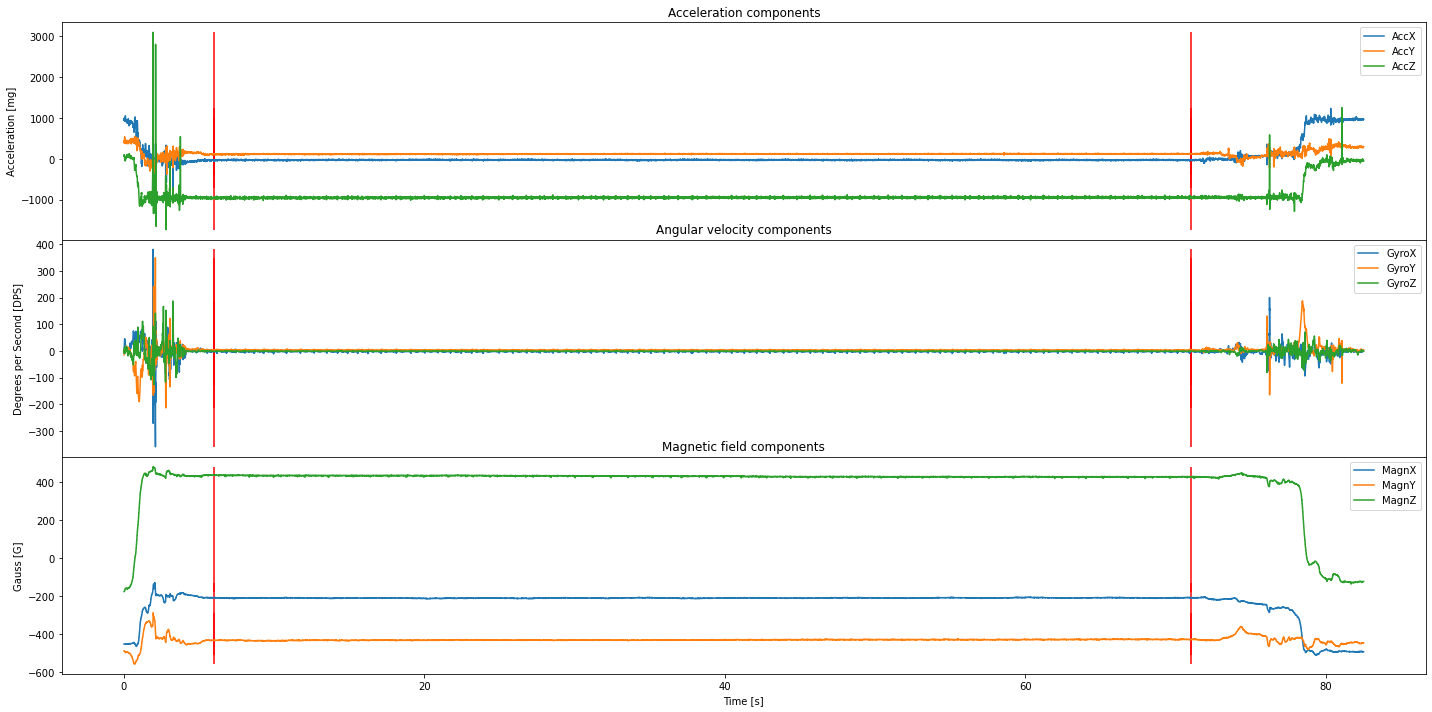

In [6]:
plot_with_timestamps(df_init,timestamp1,timestamp2)
plt.show()

The selected time-window contains the periodic signal we are interested in: let's work on the dataset corresponding to such subset. 
At this step, we also subtract the offset given by the column's mean from each column using the convenient pandas implementation.

In [7]:
# let's restrict our working time window to the one presented in the plots
df =df_init.loc[timestamp1:timestamp2] # working on the 6s-71s subset
# let's already subtract the offset given by the mean
df = df-df.mean()

We now take a closer look at each sensor component within the selected time windows:

In [8]:
def sensor_plot(data_frame, sensor, title, unit):
    """
    Helper function to plot a sensor's components.
    title : string
    unit : string 
    sensor : list of 3 string
    """
    figure, axes = plt.subplots(1, 3, figsize=(22,3))
    figure.suptitle(title)    
    colors = ['C0','C1','C2']

    for i in range(3):
        data_frame.plot(ax=axes[i],y=sensor[i], ylabel= unit, xlabel='time [s]',color=colors[i])
    

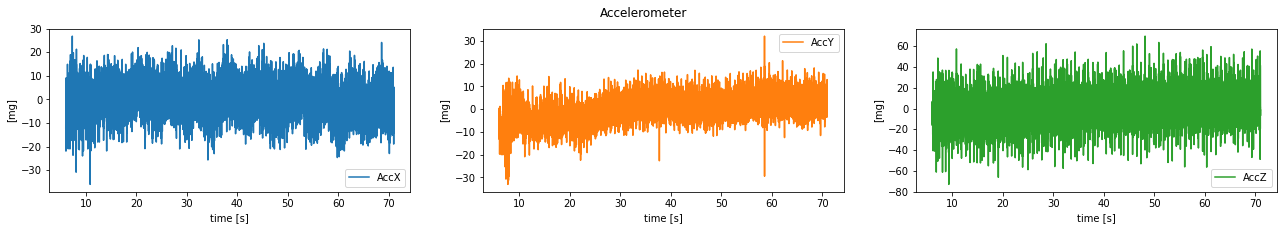

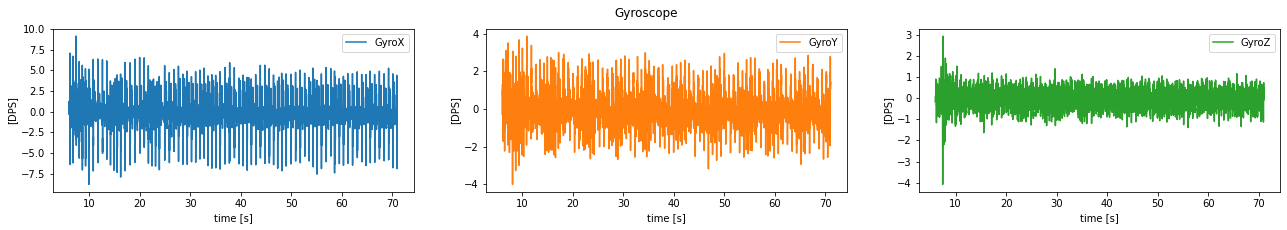

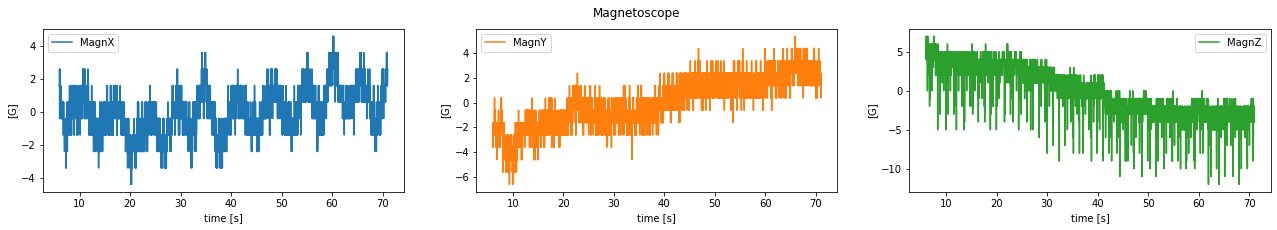

In [9]:
sensor_plot(df,acc_columns,'Accelerometer','[mg]')
sensor_plot(df,gyro_columns,'Gyroscope','[DPS]')
sensor_plot(df,magn_columns,'Magnetoscope','[G]')

From the plots shown above we observe, along with the low resolution of 1 Gauss of the magnetometer, the different contribution to the periodic signal we are looking for to different components: we can expect that, by performing a PCA, we should be able to transform the dataset into a frame of reference where the periodic signal varies mainly along one direction, assuming noise to be smaller w.r.t. the "true" signal; if that isn't the case, than variance due to gaussian noise is comparable to variance due to original signal, thus hijacking the PCA's purpose of finding the main direction of the signal.

In [10]:
def PCA_plot (data_frame, sensor, title, unit,sampling_rate=sampling_rate):
    """
    Helper function to perform PCA using sklearn's routine and plot its results.
    title : string
    unit : string 
    sensor : list of 3 string
    """
    sample_spacing = 1/sampling_rate

    pca=PCA(n_components=2) # initializing a PCA object with maximum number of kept components equal 2
    pca.fit(data_frame[sensor]) #fitting the PCA to selected sensor
    
    sensorT=pca.transform(data_frame[sensor]) # transform data; returns a np.array like (n_samples,n_components)
    
    sensorT_FT1=fft.fft(sensorT[:,0])
    sensorT_FT2=fft.fft(sensorT[:,1])
    sensorT_FT_freq=fft.fftfreq(sensorT[:,0].size,sample_spacing)
    N = int(sensorT_FT_freq.size/2) 
    hz_zoom = 0.5

    with plt.rc_context({"figure.figsize" : (20,6)}):
        fig,axs = plt.subplots(2,3,gridspec_kw={'width_ratios': [4, 2, 2]})
        fig.suptitle(title)
        axs[0,0].plot(data_frame.index,sensorT[:,0],label='First component',color='midnightblue')
        axs[0,0].legend(loc='upper right')
        axs[0,0].set_title("Transformed vector's components projection")
        axs[0,0].set_ylabel(unit)
        axs[0,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT1[:N]),color='slateblue')
        axs[0,1].set_title("FT")
        axs[0,1].set_ylabel('power')
        axs[0,2].plot(sensorT_FT_freq[:N][sensorT_FT_freq[:N]<hz_zoom],np.abs(sensorT_FT1[:N][sensorT_FT_freq[:N]<hz_zoom]),color='slateblue')
        axs[0,2].set_ylabel('power')   
        axs[1,0].plot(data_frame.index,sensorT[:,1],label='Second component',color='firebrick')
        axs[1,0].legend(loc='upper right')
        axs[1,0].set_xlabel('time [s]')
        axs[1,0].set_ylabel(unit)
        axs[1,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT2[:N]),color='tomato')
        axs[1,1].set_xlabel('frequency [Hz]')
        axs[1,1].set_ylabel('power');
        axs[1,2].plot(sensorT_FT_freq[:N][sensorT_FT_freq[:N]<hz_zoom],np.abs(sensorT_FT2[:N][sensorT_FT_freq[:N]<hz_zoom]),color='tomato')
        axs[1,2].set_ylabel('power')
        axs[1,2].set_xlabel('frequency [Hz]')
    print('*',title,'\n')
    print("Percentage of variance due to the first component: {:.2%}".format(pca.explained_variance_ratio_[0]))
    print("Percentage of variance due to the second component: {:.2%}".format(pca.explained_variance_ratio_[1]),'\n')

    return sensorT

The code above also plots the FT of the transformed dataset's components, in order to get a feeling of the frequency representation of given signal.

* Accelerometer PCA 

Percentage of variance due to the first component: 75.92%
Percentage of variance due to the second component: 13.91% 

* Gyroscope PCA 

Percentage of variance due to the first component: 79.96%
Percentage of variance due to the second component: 15.95% 

* Magnetoscope PCA 

Percentage of variance due to the first component: 81.08%
Percentage of variance due to the second component: 10.23% 



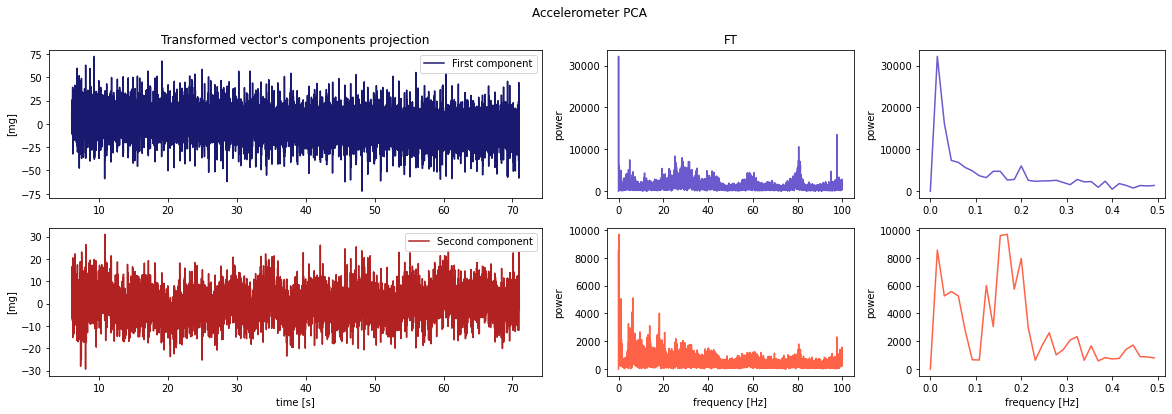

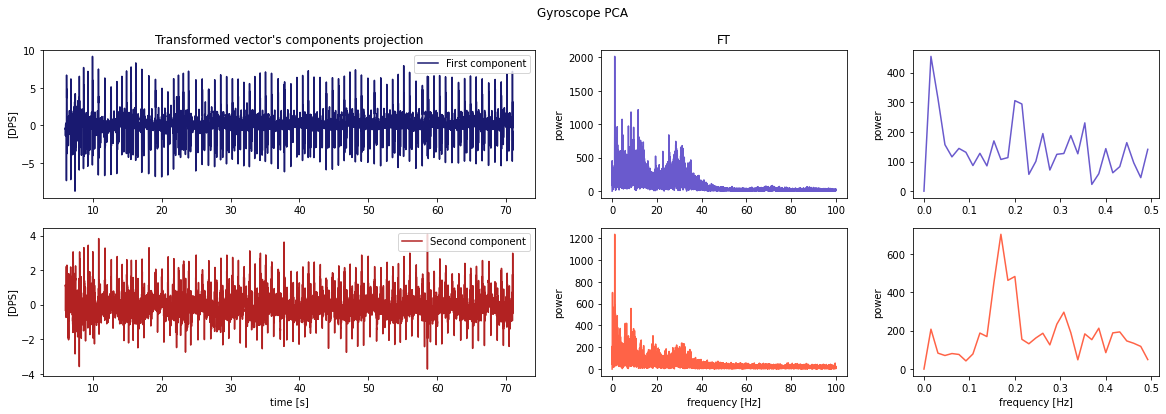

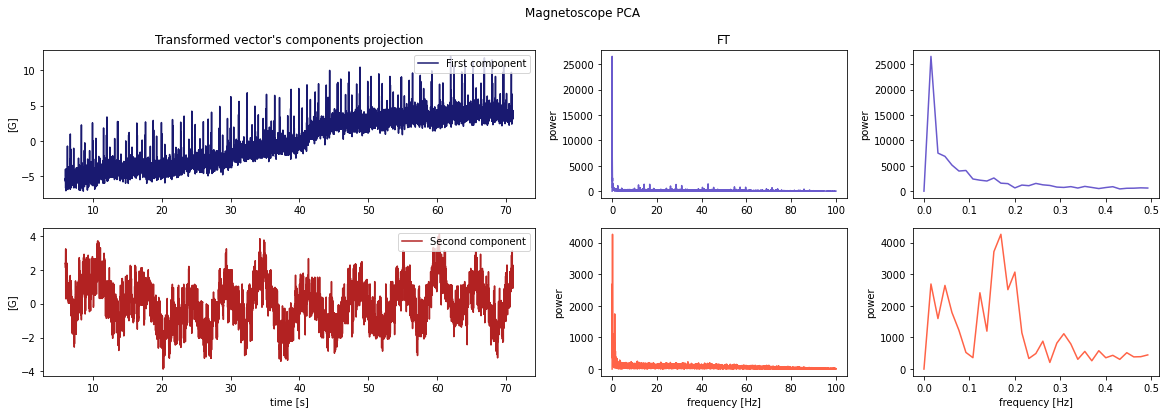

In [11]:
accT=PCA_plot(df,acc_columns,'Accelerometer PCA','[mg]')
gyroT=PCA_plot(df,gyro_columns,'Gyroscope PCA','[DPS]')
magnT=PCA_plot(df,magn_columns,'Magnetoscope PCA','[G]')

By observing the fourier transform of each PCA component, we can try to guess which of these components holds the main signal frequencies by looking at the spectrum near the low frequency spectrum ($\sim 10^{-1} Hz$). For instance, we can focus on the second component resulting from PCA over magnetometer's measurements, that shows a peak around $0.2 ~ Hz$ that roughly corresponds to a normal breathing rate.

## Time and Frequency analysis

### Low-pass filter (Butterworth filter)

A first, simple, approach, would be to tackle directly the FT of the time series and apply a low-pass filter at an arbitrary cut-off frequency equals to $0.5 ~ Hz$, which is an upper bound to the bandwidth of the respiratory signal we impose.
After applying this filter, we would simply look for a peak in the FT coefficients to estimate a dominant frequency in the signal.

In [12]:
def butter_filter(time,sensor,cutoff,order,sampling_rate,unit,component_name):
    """
    This function takes in a time series and applies Butterworth filter with a given cutoff frequency and order,
    and plots the filtered signal in time domain and in frequency domain, along with a zoomed FT within the selected bandwidth.
    Finally, it applies a gaussian fit designed to interpolate the dominant peak in order to find its frequency resolution.
    Args:
    time : np.array() of shape (n_samples), representing timestamps
    sensor : np.array() of shape (n_samples), representing the signal in time domain
    cutoff : float, cutoff frequency (Hz)
    order : int, order of the Butterworth filter
    sampling_rate : float, sampling rate (Hz)
    unit : string, goes on the label
    component_name : string, goes in the title

    Returns:
    RR : float, estimated respiratory rate due to peak finding
    RR_error : float, estimated frequency resolution found with gaussian fitting
    """
    sos = signal.butter(order, cutoff, 'lp', fs=sampling_rate, output='sos')
    filt_sensor = signal.sosfilt(sos, sensor)
    sample_spacing = 1/sampling_rate

    filt_sensor_FT=fft.fft(filt_sensor)
    filt_sensor_FT_freq=fft.fftfreq(filt_sensor.size,sample_spacing)
    N = int(filt_sensor_FT_freq.size/2) 
    filt_sensor_freq_pos = filt_sensor_FT_freq[:N]
    filt_sensor_FT_pos = np.abs(filt_sensor_FT[:N])
    
    with plt.rc_context({"figure.figsize" : (20,3)}):
        fig,axs = plt.subplots(1,2)
        axs[0].plot(time,filt_sensor)
        axs[0].set_title(component_name)
        axs[0].set_xlabel('time [s]')
        axs[0].set_ylabel(unit)
        axs[1].plot(filt_sensor_FT_freq[:N],np.abs(filt_sensor_FT[:N]))
        axs[1].set_title("FT")
        axs[1].set_xlabel('frequency [Hz]')
        axs[1].set_ylabel('power');
        
    def f(x,a,b,c,d):
        return a*np.exp(-pow(x-b,2)/(2*pow(c,2)))+d 
    
    x=filt_sensor_FT_freq[:N]
    y=np.abs(filt_sensor_FT[:N])

    zoom=np.where(x<cutoff+0.5)
    power_trashold=200

    peak=np.where(y==y.max())
    peaks=np.array(x[np.where(y>=power_trashold)])
    power_peaks=np.array(y[np.where(y>=power_trashold)])
    
    
    mask=np.where(abs(x-x[peak])<=1/np.sqrt(12)) ### da definire meglio
    

    popt, pcov = curve_fit(f, x[mask], y[mask]) 
    x_range=np.linspace(x[mask].min(),x[mask].max(),1000) 

    fig,ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].plot(x[zoom],y[zoom])
    #ax[0].scatter(peaks,power_peaks,marker='.',color='red')
    ax[0].set_title('FT')
    ax[0].set_xlabel('frequency [Hz]')
    ax[0].set_ylabel('power')
    ax[1].plot(x[mask],y[mask])
    ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
    ax[1].legend(loc='best')
    ax[1].set_title('FT')
    ax[1].set_xlabel('frequency [Hz]')
    ax[1].set_ylabel('power');

    err_perc=abs(popt[2]*100/popt[1])
    RR=60*popt[1]
    RR_error=popt[2]*60

    print(component_name)
    print('# of points to perform fit:',len(x[mask]))
    print('Fit parametres for RR:\n', popt, '\n')
    print('Respiratory rate estimated: {:.3} +/- {:.3} bpm'.format(RR, RR_error))
    print('Percentage of error: {:.3} % \n'.format(err_perc))
    
    return RR, RR_error

Let's test this routine on the second PCA component of the magnetoscope, that presented a promising peak within the low frequencies bandwidth.

Second magnetoscope PCA component filtered
# of points to perform fit: 30
Fit parametres for RR:
 [3.03843803e+03 1.67269213e-01 2.41606688e-02 8.00540782e+02] 

Respiratory rate estimated: 10.0 +/- 1.45 bpm
Percentage of error: 14.4 % 



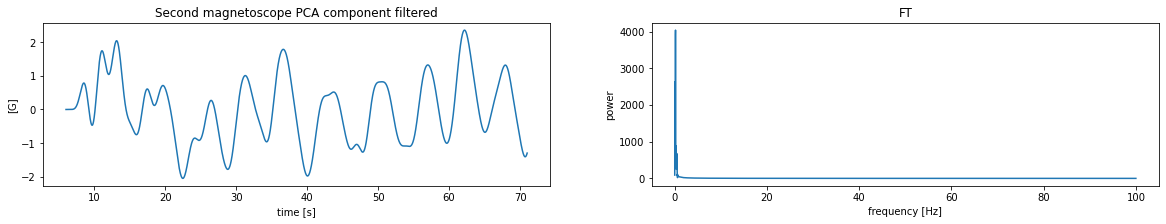

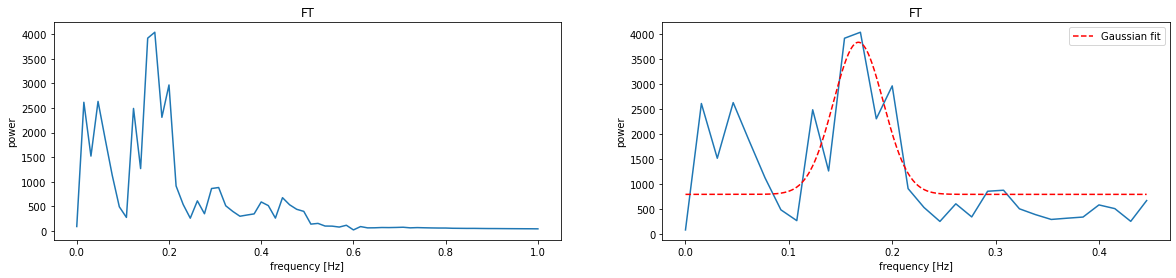

In [13]:
_,_=butter_filter(df.index.values,magnT[:,1],0.5,10,sampling_rate,'[G]','Second magnetoscope PCA component filtered')

This simple estimation, given the previous PCA decomposition, provides a satisfactory and reliable method to determine the dominant frequency in the respiratory signal.

A plain frequency analysis across the entire time domain does not inform us about time dependent information though, such as the variability of the respiratory rate through the entire data acquisition. To perform some kind of time-frequency analysis, we resort to...


# Wavelet transformation

<center><img src="img/wavelet_analysis.png" width="450"/></center>
<center>Image taken from 
<a href="https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442">this</a>
 article.</center>

Standard Fourier Transform decomposes the signal in plane waves with fixed frequency, and infinite time span; by looking at the resulting coefficients, we cannot extrapolate any information regarding time-localized events and time dependent frequency information. To perform a *Time-Frequency Analysis* one has to deploy different mathematical machines; one could, for example, perform a FT over a restricted time window of the original signal (*Short time Fourier Transform*), or, better yet, decompose the signal into a 2-dimensional basis set of wave packets, localized at some point in time $\tau$. By computing the correlation between the signal and a wave packet of a given frequency localized at a given instant, we obtain a 2D transformation carrying both time and frequency information: this is exactly what the *wavelet transform* does.
The mathematical definition of a *continuous wavelet transform* is the following:
$$
cwt(\tau,s) = \frac{1}{\sqrt{|s|}} \int_{-\infty}^{+\infty} x(t) \psi(\frac{t-\tau}{s}) dt
$$
Where $\psi$ is the *mother wavelet*, i.e. the specific type of wave we convolve with our signal, and $s$ is the *scale factor* of such mother wavelet. The suitable type of wavelet depends on the problem at hand, and the scale factor basically determines the frequency of said wavelet packet.

<center><img src="img/Continuous_wavelet_transform.gif" width="450"/></center>
<center>Image taken from 
<a href="https://en.wikipedia.org/wiki/Continuous_wavelet_transform">Wikipedia</a>.</center>

Performing the CWT upon a discrete time series $x$ of lenght $N$ with sampling period $\delta t$ results in the discrete formulation:
$$
W_n(s) = \sum_{n'=0}^{N-1} x_{n'} \psi^{*} \left[ \frac{(n' - n)\delta t}{s} \right] \overset{(*)}=  \sum_{k=0}^{N-1} \hat{x}_{k} \hat{\psi}^{*}(s\omega_k)e^{i\omega_k n \delta t}
$$

Where in $(*)$ we used the convolution theorem to perform the calculation in the frequency space, with $\hat{\psi}(s\omega_k)$ is the FT of $\psi(t/s)$. If the wavelet is, as in the general case, complex, the wavelet transform $W_n(s)$ is also complex, thus having a real and an imaginary component; to account for the modulus of the coefficients, one defines the *wavelet power spectrum* as $|W_n (s)|^2$.
Wavelets are normalized as such:
$$
\hat{\psi}(s\omega_k) = \sqrt{\frac{2\pi s}{\delta t}} \hat{\psi}_0 (s \omega_k)
$$
Since each wavelet $\psi_0$ is normalized to have unit energy:
$$
\int_{-\infty}^{+\infty} |\hat{\psi}_0(\omega')|^2 d \omega' = 1
$$

Combining these normalization we have

$$
\sum_{k=0}^{N-1} |\hat{\psi}(s\omega_k)|^2 = N
$$

So that the power spectrum is only weighted by the FT coefficients $\hat{x}_{k}$.
This gives us an interesting option as to how we can compare different scalograms by finding a common normalization spectrum, such as the spectrum due to noise:
the expectation value of $|W_n(s)|^2$, as per normalization, is $N$ times the expectation value of the FT coefficient $|\hat{x}_{k}|^2$; for (white) noise time-series, that is $\sigma^2/N$ where $\sigma^2$ is the variance, thus making the expected wavelet spectrum of white noise equal to $|W_n(s)|^2=\sigma^2$. 
By analyzing $|W_n(s)|^2/\sigma^2$, one is analyzing the power spectrum *relative* to white noise.


## Wavelets

In our study case, we employ the <a href="https://pywavelets.readthedocs.io/en/latest/">Pywavelets</a> `pywt` package that implements the continuous wavelet transform and several types of wavelets to perform the transformation with. Let's start by obtaining the list of available wavelets:

In [14]:
c_wvlst=pywt.wavelist(kind='continuous')
print(c_wvlst)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


Official <a href="https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#continuous-wavelet-families">Pywavelets documentation</a> provides a more detailed explanation of the previously printed wavelets, along with their mathematical formulation. Each of these wavelets has a "central frequency" $f_C$, i.e. the wave packet's peak frequency when its scale factor is set to 1. For instance, pick the Morlet wavelet `morl`, defined in the documentation as
$$
\psi_{Morlet}(t) = e^{-t^2/2}\cos(5t)
$$
When scaled by a factor of 1, this (and any other) wavepacket is evaluated within a range where it's assumed to be non-zero: when selecting a larger scale factor, the wavelet's range is extended by the same factor, making it more sensible to lower frequencies in the signal. Pywavelets's Wavelet Objects carry these informations and properties:


Wavelet's name:  morl
Wavelet's upper bound:  8.0
Wavelet's lower bound:  -8.0
Is the wavelet biorthogonal?  False
Is the wavelet symmetric?  symmetric
Central frequency:  0.8125


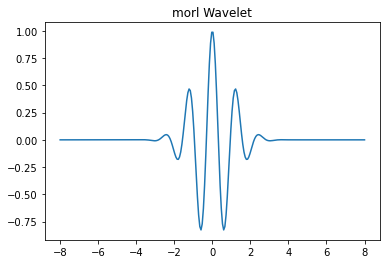

In [15]:
def get_wavelet_description(name):
    """
    Helper function to get informations about a Wavelet Object provided by the pywt package.
    name : string representing a wavelet name as defined by pywt.wavelist()
    """
    # initialize a wavelet object
    wav = pywt.ContinuousWavelet(name)
    wavy,wavx=wav.wavefun()
    print("Wavelet's name: ",wav.name)
    print("Wavelet's upper bound: ",wav.upper_bound)
    print("Wavelet's lower bound: ",wav.lower_bound)
    print("Is the wavelet biorthogonal? ",wav.biorthogonal)
    print("Is the wavelet symmetric? ",wav.symmetry)
    print("Central frequency: ",pywt.scale2frequency(wav,1)) #scale2frequency is a pywt function that returns the frequency at a given scale

    fig,ax = plt.subplots()
    ax.set_title('{} Wavelet'.format(name))
    ax.plot(wavx,wavy)
    plt.show()

get_wavelet_description('morl') #Morlet Wavelet

Note: the frequency returned by the function `scale2frequency` is a *pseudy-frequency* $\hat{f}$: it's only equal to the real physical frequency if the sampling period is assumed to be 1 s (sampling frequency of 1 Hz). In order to get the corresponding physical central frequency of it we need to multiply it by the sampling frequency:
$$
f_C = \hat{f_C}f_{sampling}
$$
Since the frequency of a wavelet is inversely proportional to the scale factor $f(s)=\hat{f_C}f_{sampling}/s$, in order to find the scale factor corresponding to a specific frequency we explicitate:
$$
s(f) = \frac{\hat{f_C}f_{sampling}}{f}
$$

This helps us set a minimum scale value $s_0$, corresponding to the maximum frequency which turns out to be half the sampling frequency as per Nyquist-Shannon's theorem:

$$
s_{0} = 2\hat{f_C}
$$

The choice of the finite set of scale factors is arbitrary and can be used to build up a more complete picture; we will use a linearly spaced scales sampling between a maximum central frequency and a minimum central frequency of the decomposing wavelets. The maximum frequency that can be resolved is given by $s_0$, and the minimum will be arbitrarily set by us to around $0.1 ~ Hz$, since the respiratory signal is very unlikely to have a lower frequency than this; lower frequencies would take a long time to convolve because their support is much larger.

In [16]:
def get_scales(wav,min_freq,max_freq,sampling_rate,Nscales=500,verbose=False):
    """
    Function to get a discrete array of scale factors to perform CWT. 
    Inputs:
    wav : wavelet name (string) or Wavelet object
    min_freq : float, minimum central frequency desired (Hz)
    max_freq : float, maximum central frequency desired (Hz)
    sampling_rate : float, sampling rate of the time series (Hz)
    Nscales=500 : int, number of scale factors
    verbose=False : bool, print results
    """
    min_scale = pywt.scale2frequency(wav,1)*sampling_rate/max_freq
    max_scale = pywt.scale2frequency(wav,1)*sampling_rate/min_freq
    scales = np.linspace(min_scale,max_scale,Nscales)
    if verbose:
        print("Central real frequency (Hz) of wavelet {}: ".format(str(wav)),pywt.scale2frequency(wav,1)*sampling_rate)
        print("Minimum scale factor for a frequency of {} Hz: {}".format(max_freq,min_scale))
        print("Maximum scale factor for a frequency of {} Hz: {}".format(min_freq,max_scale))

    return scales


### CWT implementation

Let's now perform the CWT using `pywt`'s routine; this returns a `np.array` of shape `(n_scales,n_samples)` representing the CWT coefficients (`coefs`). The element `coefs[i,:]` represents a horizontal slice of the scalogram $W_n(s)$.
We will use a complex-valued wavelet, since it better captures oscillatory behaviour by conveying information also about the phase; using a real valued wavelet results in a "bumpy" scalogram for oscillatory phenomena due to the out-of-phase regions of the time series.
`pywt` allows us to define a continuous complex Morlet wave by calling `cmorB-C` where `B` and `C` are float numbers representing the bandwidth and the central frequency of the wavelet:

$$
\psi_{complex}(t)=\frac{1}{\sqrt{\pi B}}e^{-t^2/B}e^{i2\pi Ct}
$$

### Cone of Influence (COI)
Now, a note on boundary artifacts: since the time series is finite, even with padding we will have artifacts at the boundary. The "persistence" of these artifacts is longer for longer wavelets: we want to estimate a so called *cone of influence (COI)* as the set of points in the scalogram such that
$$
COI = \{ s,t | t>t_a + \hat{\tau}_{decay}(s) \land t<t_b - \hat{\tau}_{decay}(s) \}
$$
Where $\hat{\tau}$ is defined as some sort of *time constant* after which the autocorrelation of the wavelet decays by a factor of $e^{-2}$. In the case of the complex valued Morlet wave we defined, we can calculate it:
$$
\bra{\psi(t)}\ket{\psi(t+\tau)} = \int_{-\infty}^{+\infty} \frac{dt}{\pi B} e^{-\frac{(t+\tau)^2}{s^2 B}} e^{i2\pi C (t+\tau)/s}e^{-\frac{t^2}{s^2B}}e^{-i2\pi C t/s}= \frac{e^{i2\pi C \tau / s}}{\pi B} \int_{-\infty}^{+\infty} dt e^{-\frac{2t^2 + 2\tau t + \tau^2}{s^2B}}
$$
The latter is a gaussian integral; solving it leads to
$$
\bra{\psi(t)}\ket{\psi(t+\tau)} = \frac{s}{\sqrt{2\pi B}} e^{i2\pi c \tau /s} e^{-\frac{\tau^2}{2s^2B}}
$$

Which gives us a time constant for the decay of a factor $e^{-2}$ of 
$$
\hat{\tau}_{decay}(s) = 2s\sqrt{B}
$$
This then needs to be multiplied by the sampling period to get the corresponding real-time.

In the cells below, we define a few functions to plot the COI and the power spectrum (defined as $|W_n(s)|^2$), since it's the modulus of the (complex) coefficients that carries the information about correlation, and we neglect phase information. 

In [17]:
def make_spectrogram(coefs,scales,t_series,title,cmap='jet'):
    """
    Function that plots the scalogram of the decomposed signal. 
    Plots the scalogram with x axis corresponding to the time-series
    And y axis corresponding to scale array (assuming linearly spaced scale factors)
    Because of poorly implemented imshow() method of matplotlib.
    Arguments:
    coefs : np.array() shaped like (n_scales,n_samples)
    scales : np.array() shaped like (n_scales), with each entry scales[i] being the scale factor used in coefs[i,:]
    t_series : np.array() shaped like (n_samples), giving the timestamp of each sample
    title : string, title of the scalogram
    cmap : defaults to 'viridis', string representing a Matplotlib cmap name
    """
    fig,ax = plt.subplots(1,1,figsize=[20,8])
    ax.set_title(title)
    ax.set_ylabel('Wavelet Scale Factor')
    pos = ax.imshow(coefs,aspect='auto',extent=(t_series[0],t_series[-1],scales[-1],scales[1]),cmap=cmap)
    f = lambda s : pywt.scale2frequency(wav,s)*sampling_rate
    finv = lambda f : pywt.scale2frequency(wav,1)*sampling_rate/f
    secax=ax.secondary_yaxis('right')
    # print(secax.get_yticks())
    cbar=fig.colorbar(pos)
    cbar.set_label(r'$|W|^2 / \sigma^2$')
    ax.set_xlabel('Time (s)')
    return fig,ax

def get_COI_time_morlet(B,scales,sampling_rate):
    """
    Returns an array of real time values corresponding to 2 e-folding time at a given Morlet wavelet scale.
    B : float, Morlet wavelenght bandwidth
    scales : np.array of scale factors
    sampling_rate : float, sampling rate in frequency
    """
    t = 2*scales*np.sqrt(B)/sampling_rate
    return t

def plot_coi_over_spectrogram(ax,B,scales,sampling_rate,time):

    """
    Takes an ax as input and returns it with COI cone plotted.
    ax : matplotlib Axes obj
    B : float, Morlet wavelenght bandwidth
    scales : np.array of scale factors
    sampling_rate : float, sampling rate in frequency
    time : np.array representing timestamps
    """
    t = time[0] + get_COI_time_morlet(B,scales,sampling_rate)
    t2 = time[-1] - get_COI_time_morlet(B,scales,sampling_rate)
    ax.fill_between(t,scales,y2=scales[-1],hatch='|',color='black',alpha=0.3,label='COI exclusion zone')
    ax.fill_between(t2,scales,y2=scales[-1],hatch='|',color='black',alpha=0.3)
    ax.autoscale(False)

    return ax


## Spectrogram quantitative analysis

A spectrogram (or more precisely scalogram when plotted against the scale factors) is highly informative in terms of qualitative observations, but a precise quantitative analysis is not trivial: we will implement in a simple way a few ideas from the Torres-Compo (1998) paper, from which we got the concept of COI in the first place. 
The main idea is to compare the power spectrum $|W_n(s)|^2$ to a white noise background (or some other type of noise based on previous knowledge of the problem); then, the null hypothesis is that each point of the scalogram is drawn by white-noise gaussian distribution (which is normal with variance $\sigma^2$ being the variance of the spectrum); we then establish a confidence level to be above $95\%$ : that is we evaluate the $\chi^2_2(1-\alpha)$ (with 2 degrees of freedom for complex wavelets since both the real and imaginary part are drawn from a gaussian distribution) with $\alpha=0.05$, and then assert that every (normalized) power spectrum coefficient that exceeds this staistical threshold is due to a signal and not white noise:
$$
\frac{|W_n(s)|^2}{\sigma^2} = \frac{1}{2}\chi^2_2 \delta t
$$

with $\delta t =1/f_s$ being the sampling period.

Then, for a simple time-frequency quantitative analysis, we take the maximum power coefficient for each time instant, and then apply a moving average to this time series: that is, convolve it with a boxcar function that results in a low band pass filter, effectively reducing high-frequency contribution that are possibly due to noise (i.e. we don't expect the respiratory rate to change abruptly).

In [39]:

def peak_seeking(power_spectrum,B,scales,sampling_rate,time,N=50):
    """
    Takes a Power Spectrum and returns a rolling average of the maximum scale coefficient at each point in time.
    power_spectrum : (n_scales,n_samples) np.array
    B : float, Morlet wavelenght bandwidth
    scales : np.array of scale factors
    sampling_rate : float, sampling rate in frequency
    time : np.array representing timestamps in real seconds
    N : int, defaults to 50, window size
    
    Returns:
    scales_max_avrg : np.array of size (n_samples) representing the averaged peaks
    mask : boolean mask for scales_max_avrg, corresponding to points inside the COI 
    """
    scale_max=np.argmax(power_spectrum,axis=0)
    N=50
    scales_max_avrg=np.convolve(scales[scale_max], np.ones(N)/N,mode='same') # windowed mean, this produces edges artifacts but they are usually outside of COI
    mask = np.zeros_like(scales_max_avrg,dtype=bool)
    for i in range(len(mask)):
        mask[i]= (time[i]>time[0] + 2*scales_max_avrg[i]*np.sqrt(B)/sampling_rate) & (time[i]<time[-1] - 2*scales_max_avrg[i]*np.sqrt(B)/sampling_rate)


    return scales_max_avrg,mask


def plot_confidence_region_safe(ax,pwr_norm,f_sampling,time,scales):
    """
    Safe alternative to plot the confidence region, does not use fill_between
    """
    CL = 0.5*5.99*(1/f_sampling) # CL 95%
    (y,x)=np.where(pwr_norm>CL)
    ax.plot(time[x],scales[y],'o',color='violet',alpha=0.5)
    return ax

def plot_confidence_region_test(ax,pwr_norm,f_sampling,time,scales):
    """
    POORLY IMPLEMENTED

    Takes an Axes object and plots the region above the confidence level for a normalized power spectrum.
    Only works if conficence region is convex :(
    Args:
    ax : Axes obj
    pwr_norm : power spectrum normalized to its variance shaped like (n_scales,n_samples)
    f_sampling : float, sampling rate of the signal (Hz)
    time : time axis, 1d array like (n_samples)
    scales : scale axis, 1d array like (n_scales)
    
    Returns:
    ax : Axes object with the confidence region plotted
    time_cf : np.array() of the x coordinates of the region
    scales_cf : np.array() shaped like (time_cf.size,2) determining the lower and upper bound of the confidence region
    """

    CL = 0.5*5.99*(1/f_sampling) # CL 95%
    (y,x)=np.where(power_spectrum_normalized>CL)
    idces=np.argsort(x)
    x=x[idces]
    y=y[idces]
    x_t = []
    y_t = []
    xunique,xunique_indices,xunique_counts=np.unique(x,return_counts=True,return_index=True)
    for idx,count in zip(xunique_indices,xunique_counts):
        x_t.append(x[idx])
        y_t.append((np.min(y[idx:idx+count]),np.max(y[idx:idx+count])))
    

    x_t,y_t=np.array(x_t),np.array(y_t)
    time_cf = time[x_t]
    scales_cf = np.array((scales[y_t[:,0]],scales[y_t[:,1]])).T
    N=50
    scales_cf[:,0] = np.convolve(scales_cf[:,0], np.ones(N)/N,mode='same')
    scales_cf[:,1] = np.convolve(scales_cf[:,1], np.ones(N)/N,mode='same')
    K = N # to avoid border convolutional effects
    ax.fill_between(time_cf[K:-K],scales_cf[:,0][K:-K],scales_cf[:,1][K:-K],hatch='x',color='violet',alpha=0.5,label='Confidence above 95% region')



    return ax,time_cf,scales_cf

### CWT 
First, we apply all of the methods developed so far to the same second component of the PCA transformed magnetometer measurements: 

In [40]:
data_in = magnT[:,1]
B=1.0
C=1.0
wav = 'cmor'+str(B)+'-'+str(C)
scales = get_scales(wav,0.1,100,sampling_rate,500,True)


Central real frequency (Hz) of wavelet cmor1.0-1.0:  200.0
Minimum scale factor for a frequency of 100 Hz: 2.0
Maximum scale factor for a frequency of 0.1 Hz: 2000.0


In [20]:
# CWT
coefs,cwt_freq = pywt.cwt(data_in,scales,wav,1/sampling_rate)

In [21]:
power_spectrum = np.abs(coefs)**2
var_spectr = np.var(power_spectrum)
power_spectrum_normalized = power_spectrum/var_spectr

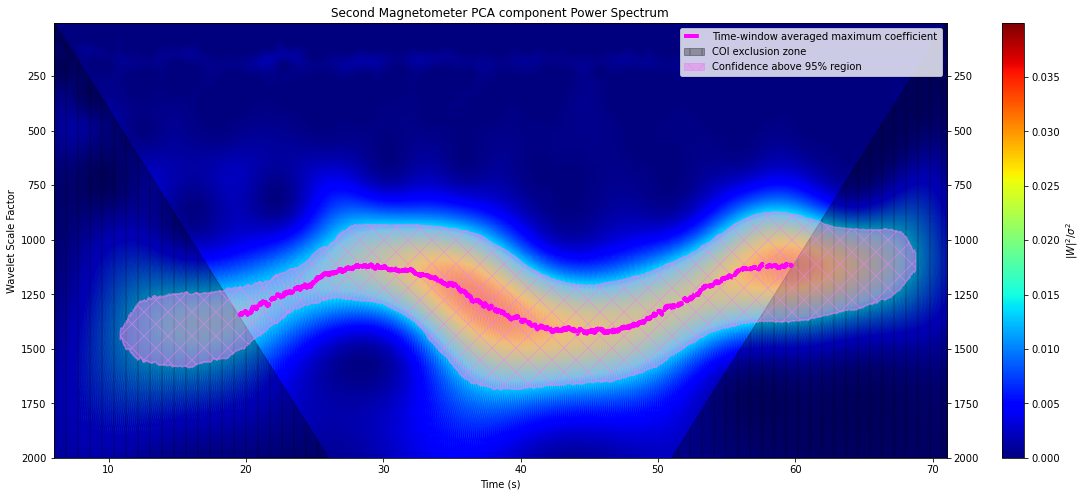

In [22]:
# spectrogram
fig,ax=make_spectrogram(power_spectrum_normalized,scales,df.index,'Second Magnetometer PCA component Power Spectrum')
# ax.plot(df.index.values[x],scales[y],'o',alpha=0.01,color='gray')
ax=plot_coi_over_spectrogram(ax,B,scales,sampling_rate,df.index.values)
# maximum seeking
scales_max_avrg,mask=peak_seeking(power_spectrum,B,scales,sampling_rate,df.index.values)
ax.plot(df.index.values[mask],scales_max_avrg[mask],linestyle='--',linewidth=4,color='magenta',label='Time-window averaged maximum coefficient')
#confidence level 
ax,time_cf,scales_cf= plot_confidence_region_test(ax,power_spectrum,sampling_rate,df.index.values,scales)

ax.legend();

After finding the scale factor with maximum correlation with the signal for each point in time $t$ and averaging it with a low pass filter, we plot the corresponding Fourier frequency along with a bandwidth defined as the Full Width ad Half Maximum (FWHM) of the gaussian packet in the frequency space for every scale factor: since the wave packet in the time domain is modulated with a gaussian of variance $\sigma_t = \sqrt{2B} s$, in the frequency space $\sigma_f = 1/\sigma_t$:

RR time average: 0.159 Hz (9.52 bpm)
RR time std: 0.0179 Hz (1.07 bpm)


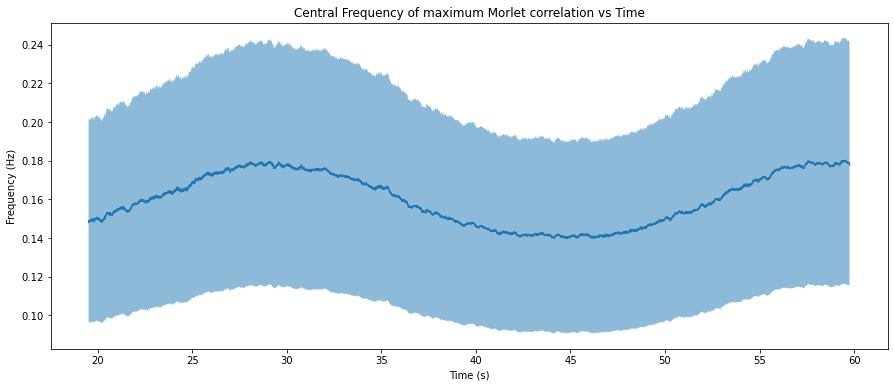

In [23]:
freqs_max_avrg = np.array([pywt.scale2frequency(wav,scale)*sampling_rate for scale in scales_max_avrg])


freq_upper = freqs_max_avrg + sampling_rate/(2*np.sqrt(2*B)*scales_max_avrg) # translating into real frequency still requires the sampling rate
freq_lower = freqs_max_avrg - sampling_rate/(2*np.sqrt(2*B)*scales_max_avrg)


fig,axs = plt.subplots(1,1,figsize=[15,6])
axs.set_title('Central Frequency of maximum Morlet correlation vs Time')
axs.fill_between(df.index.values[mask],freq_lower[mask],freq_upper[mask],alpha=0.5)
axs.plot(df.index.values[mask],freqs_max_avrg[mask])
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")


mean_final=np.mean(freqs_max_avrg)
std_final=np.std(freqs_max_avrg)
print('RR time average: {:.3} Hz ({:.3} bpm)'.format(mean_final,mean_final*60))
print('RR time std: {:.3} Hz ({:.3} bpm)'.format(std_final,std_final*60))

This concludes the quantitative time-frequency analysis of the first dataset; wavelet transformation, albeit subject to such a simple analysis, provides a powerful instrument to estimate respiratory rate and its temporale dependence. Now we move on to the next dataset and perform the same analysis.

# Second dataset: `4_Chest_sweater.txt`

During this data acquisition, the sensor is placed on the subject chest directly on a sweater. Let's proceed to the same kind of analysis.

In [24]:
df_init2,sampling_rate2=Data_Frame('4_Chest_sweater.txt')
print("Dataset sampling rate: {} Hz".format(sampling_rate2))
df_init2

Dataset sampling rate: 100 Hz


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
time_s,,,,,,,,,
0.00,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113
0.01,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128
0.02,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136
0.03,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145
0.04,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157
...,...,...,...,...,...,...,...,...,...
149.33,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50
149.34,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51
149.35,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54


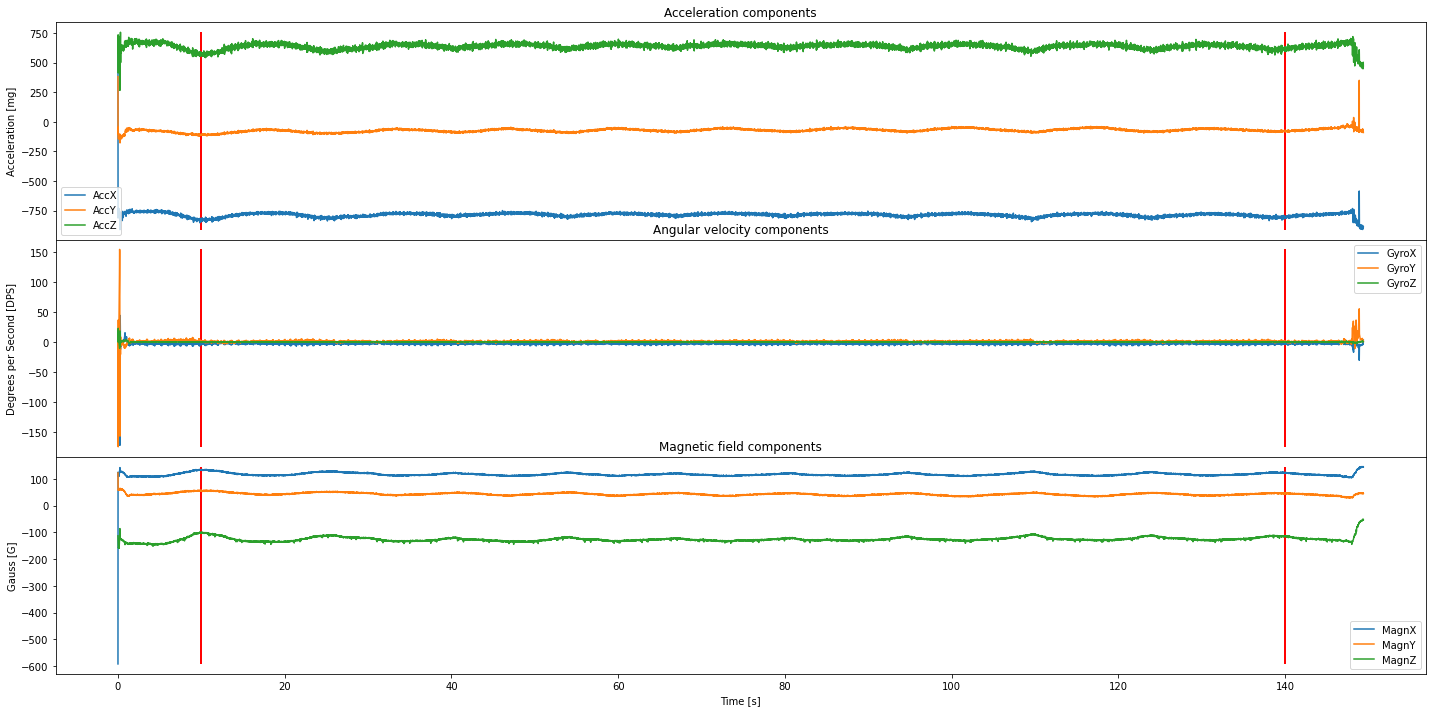

In [25]:
timestamp1 = 10
timestamp2 = 140

fig,axs = plt.subplots(3,1,sharex=True,figsize=[20,10],gridspec_kw={'hspace': 0})
# plot the acceleration vectors
axs[0].set_title('Acceleration components')
for acc in acc_columns:
    axs[0].vlines(timestamp1,df_init2[acc_columns].min().min(),df_init2[acc_columns].max().max(),color='red')
    axs[0].vlines(timestamp2,df_init2[acc_columns].min().min(),df_init2[acc_columns].max().max(),color='red')
    axs[0].plot(df_init2.index,df_init2[acc],label=acc)
    axs[0].set_ylabel('Acceleration [mg]')
# plot the angular velocity components
axs[1].set_title('Angular velocity components')
for gyro in gyro_columns:
    axs[1].vlines(timestamp1,df_init2[gyro_columns].min().min(),df_init2[gyro_columns].max().max(),color='red')
    axs[1].vlines(timestamp2,df_init2[gyro_columns].min().min(),df_init2[gyro_columns].max().max(),color='red')
    axs[1].plot(df_init2.index,df_init2[gyro],label=gyro)
    axs[1].set_ylabel('Degrees per Second [DPS]')
# plot the magnetic field components
axs[2].set_title('Magnetic field components')
for magn in magn_columns:
    axs[2].vlines(timestamp1,df_init2[magn_columns].min().min(),df_init2[magn_columns].max().max(),color='red')
    axs[2].vlines(timestamp2,df_init2[magn_columns].min().min(),df_init2[magn_columns].max().max(),color='red')
    axs[2].plot(df_init2.index,df_init2[magn],label=magn)
    axs[2].set_ylabel('Gauss [G]')
for ax in axs:   ax.legend()
axs[-1].set_xlabel('Time [s]')
fig.tight_layout()
plt.show()

In [26]:
# let's restrict our working time window to the one presented in the plots
df2 =df_init2.loc[timestamp1:timestamp2]
# let's already subtract the offset given by the mean
df2 = df2-df2.mean()

* Accelerometer PCA 

Percentage of variance due to the first component: 83.59%
Percentage of variance due to the second component: 10.32% 

* Gyroscope PCA 

Percentage of variance due to the first component: 75.76%
Percentage of variance due to the second component: 22.00% 

* Magnetoscope PCA 

Percentage of variance due to the first component: 89.99%
Percentage of variance due to the second component: 8.90% 



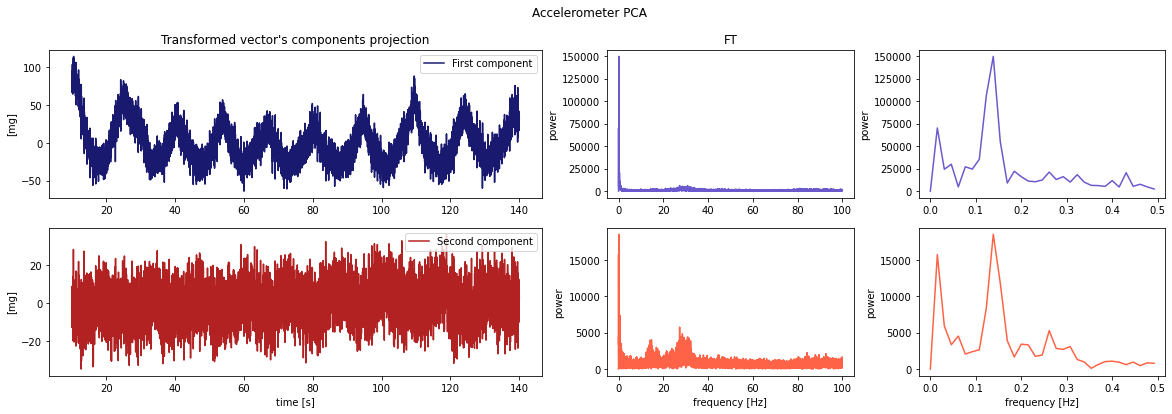

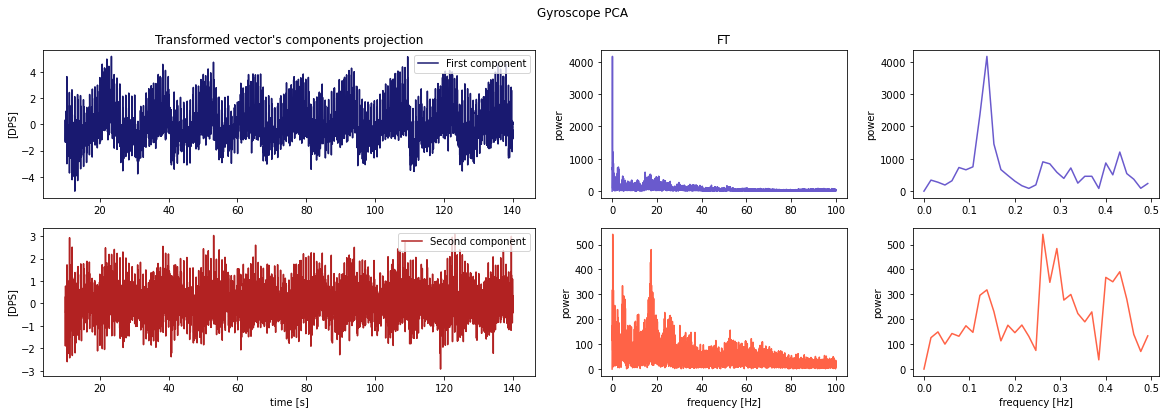

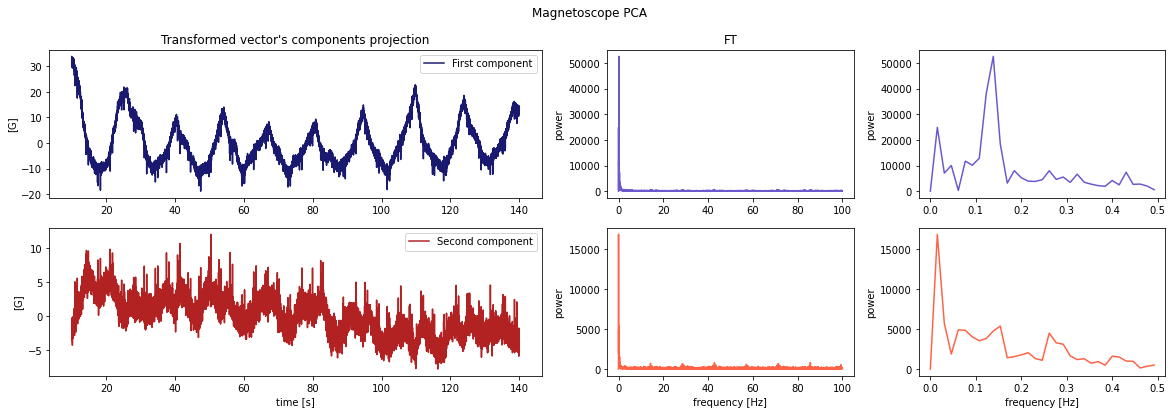

In [27]:
accT2=PCA_plot(df2,acc_columns,'Accelerometer PCA','[mg]')
gyroT2=PCA_plot(df2,gyro_columns,'Gyroscope PCA','[DPS]')
magnT2=PCA_plot(df2,magn_columns,'Magnetoscope PCA','[G]')

### CWT 
Again, let's try our procedure on this dataset, choosing again the first PCA transformed magnetometer's component.

In [28]:
data_in = magnT2[:,0]
B=1.0
C=1.0
wav = 'cmor'+str(B)+'-'+str(C)
scales = get_scales(wav,0.1,sampling_rate2/2,sampling_rate2,500,True) # maximum frequency is now 50 Hz

Central real frequency (Hz) of wavelet cmor1.0-1.0:  100.0
Minimum scale factor for a frequency of 50.0 Hz: 2.0
Maximum scale factor for a frequency of 0.1 Hz: 1000.0


In [29]:
# CWT
coefs,cwt_freq = pywt.cwt(data_in,scales,wav,1/sampling_rate2)

In [30]:
power_spectrum = np.abs(coefs)**2
var_spectr = np.var(power_spectrum)
power_spectrum_normalized = power_spectrum/var_spectr

Power spectrum above threshold: 0.00%


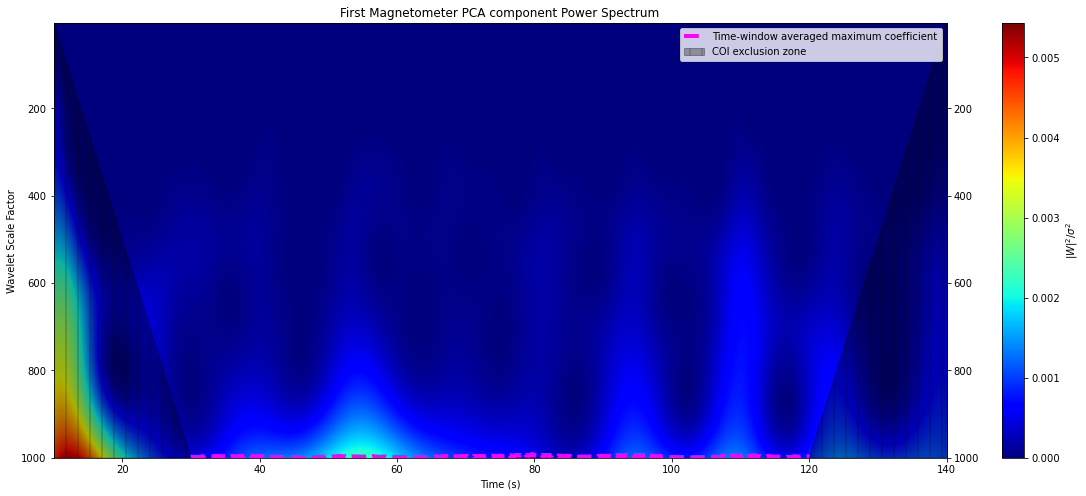

In [31]:
# spectrogram
fig,ax=make_spectrogram(power_spectrum_normalized,scales,df2.index,'First Magnetometer PCA component Power Spectrum')
# ax.plot(df.index.values[x],scales[y],'o',alpha=0.01,color='gray')
ax=plot_coi_over_spectrogram(ax,B,scales,sampling_rate2,df2.index.values)
# maximum seeking
scales_max_avrg,mask=peak_seeking(power_spectrum_normalized,B,scales,sampling_rate2,df2.index.values)
ax.plot(df2.index.values[mask],scales_max_avrg[mask],linestyle='--',linewidth=4,color='magenta',label='Time-window averaged maximum coefficient')

# ax = plot_confidence_region_safe(ax,power_spectrum_normalized,sampling_rate2,df2.index.values,scales)
# NOT PLOTTING CONFIDENCE REGION
# because almost everything is above the confidence level: 
CL = 0.5*5.99*(1/sampling_rate2) # CL 95%
(y,x)=np.where(power_spectrum_normalized>CL)
print("Power spectrum above threshold: {:.2%}".format(y.size/power_spectrum_normalized.size))

ax.legend();

As we can see from the spectrogram, the peak finding algorithm fails badly because of low frequency noise, that is clearly visible from the time representation of the signal shown in the PCA part. This low frequency component is much more intense than the signal we are looking for and as such won't be ignored by the simple algorithm we built. We can either try another PCA component until mean RR is well within plausible values, or resort to the simpler FT analysis. 

We will do both: starting with CWT procedure on another PCA component, we try the second gyroscope component that, judging by the fourier spectrum, carries less low-frequency noise and presents a first peak at around 0.1-0.2 Hz.

In [32]:
data_in = gyroT2[:,1]
B=1.0
C=1.0
wav = 'cmor'+str(B)+'-'+str(C)
scales = get_scales(wav,0.1,sampling_rate2/2,sampling_rate2,500,True) # maximum frequency is now 50 Hz

Central real frequency (Hz) of wavelet cmor1.0-1.0:  100.0
Minimum scale factor for a frequency of 50.0 Hz: 2.0
Maximum scale factor for a frequency of 0.1 Hz: 1000.0


In [33]:
# CWT
coefs,cwt_freq = pywt.cwt(data_in,scales,wav,1/sampling_rate2)

In [34]:
power_spectrum = np.abs(coefs)**2
var_spectr = np.var(power_spectrum)
power_spectrum_normalized = power_spectrum/var_spectr

Power spectrum above threshold: 77.54%


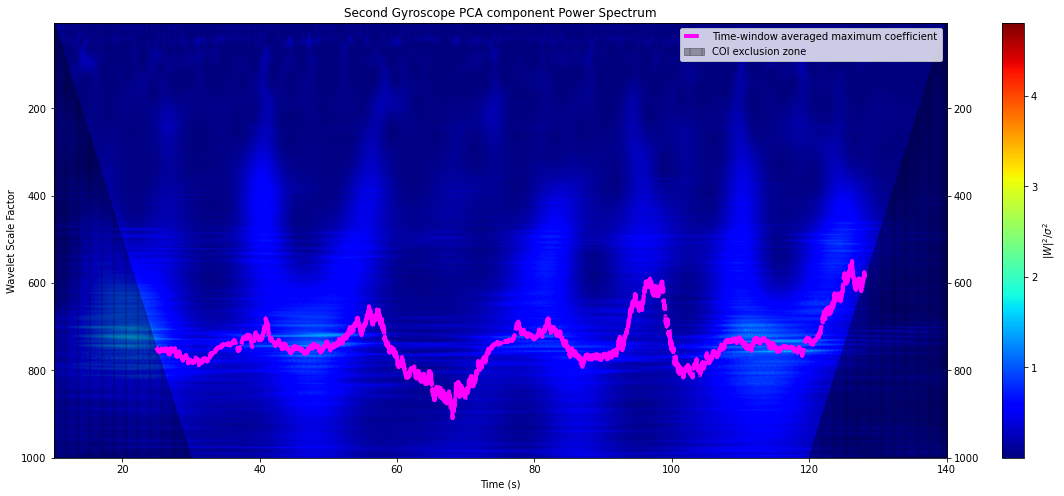

In [35]:
# spectrogram
fig,ax=make_spectrogram(power_spectrum_normalized,scales,df2.index,'Second Gyroscope PCA component Power Spectrum')
# ax.plot(df.index.values[x],scales[y],'o',alpha=0.01,color='gray')
ax=plot_coi_over_spectrogram(ax,B,scales,sampling_rate2,df2.index.values)
# maximum seeking
scales_max_avrg,mask=peak_seeking(power_spectrum_normalized,B,scales,sampling_rate2,df2.index.values)
ax.plot(df2.index.values[mask],scales_max_avrg[mask],linestyle='--',linewidth=4,color='magenta',label='Time-window averaged maximum coefficient')

# ax = plot_confidence_region_safe(ax,power_spectrum_normalized,sampling_rate2,df2.index.values,scales)
# NOT PLOTTING CONFIDENCE REGION
# because almost everything is above the confidence level: 
CL = 0.5*5.99*(1/sampling_rate2) # CL 95%
(y,x)=np.where(power_spectrum_normalized>CL)
print("Power spectrum above threshold: {:.2%}".format(y.size/power_spectrum_normalized.size))

ax.legend();

RR time average: 0.136 Hz (8.17 bpm)
RR time std: 0.0108 Hz (0.645 bpm)


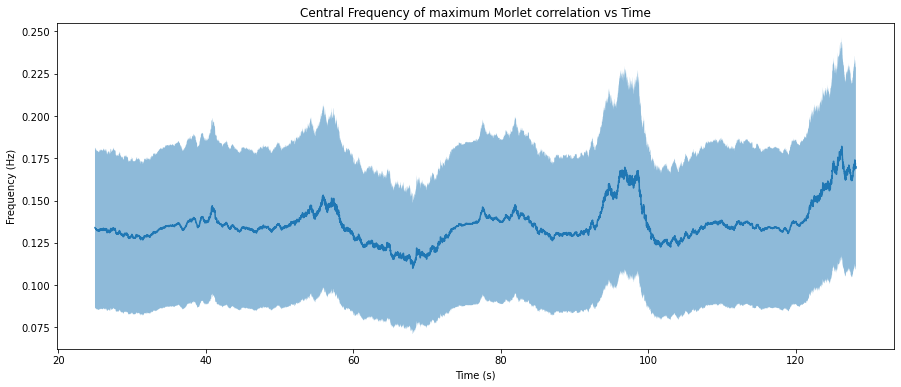

In [36]:
freqs_max_avrg = np.array([pywt.scale2frequency(wav,scale)*sampling_rate2 for scale in scales_max_avrg])


freq_upper = freqs_max_avrg + sampling_rate2/(2*np.sqrt(2*B)*scales_max_avrg) # translating into real frequency still requires the sampling rate
freq_lower = freqs_max_avrg - sampling_rate2/(2*np.sqrt(2*B)*scales_max_avrg)


fig,axs = plt.subplots(1,1,figsize=[15,6])
axs.set_title('Central Frequency of maximum Morlet correlation vs Time')
axs.fill_between(df2.index.values[mask],freq_lower[mask],freq_upper[mask],alpha=0.5)
axs.plot(df2.index.values[mask],freqs_max_avrg[mask])
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")


mean_final=np.mean(freqs_max_avrg)
std_final=np.std(freqs_max_avrg)
print('RR time average: {:.3} Hz ({:.3} bpm)'.format(mean_final,mean_final*60))
print('RR time std: {:.3} Hz ({:.3} bpm)'.format(std_final,std_final*60))

### Final observation on CWT method 

Trying a different sensor results in a plausible RR evolution, compatible with the peaks observed with simple Fourier analysis.
Then why didn't the CWT detect such peaks in the first place?
A possible culprit could be identified in the scale factors chosen for the decomposition: picking them evenly spaced in the scales space actually results in unevenly spaced central frequencies since $f\sim 1/s$, resulting in the low end spectrum being too finely sampled and possibly ending up with a much higher wavelet-noise correlation when the frequencies sync up; a possible future improvement of the algorithm could be a choice of scales artfully designed to sample more finely the bandwitdh we are interested in, hopefully reducing the variance due to other components and have a more likely correlation between the signal and the scales sampled.

Also, the assumption of a white noise could be unsuitable for the problem at hand: a different background spectrum such as red noise (more intense at lower frequencies) could be more useful to extract signal information.

Finally, a more robust peak finding algorithm that takes into account the actual spectrum at each instant would provide a less erratic behaviour of the resulting time series.

Another key element is the automation of the process: in this notebook, we manually selected the time series to be subject of the CWT; an automated estimation that starts from the raw dataset could determine the most suitable component via some distribution analysis of the spectrum finding the most suitable one for the process at hand (respiration).

A single sensor time series could be subject to different noise w.r.t. some other sensor (e.g. gyroscope vs magnetometer); a way to circumvent this problem would be to consider *multiple* signals by defining a *Cross Wavelet spectrum*: considering two time series $X$ and $Y$, that would be defined as $W_n^{XY}(s)=W_n^X(s)W_n^{Y^*}(s)$ with $W_n^{Y^*}(s)$ being the complex conj. of $W_n^{Y}(s)$.

This and many other concepts that could prove useful of the Wavelet analysis, which is still a very recent and alive field of research, were taken from the Torrence-Compo paper already mentioned and cited in the bibliography.

## Butterworth Filter

As a final, simpler approach to this noisy dataset, we deploy our beloved Butterworth filter and estimate peaks via a Gaussian fit; we do this once for every sensor reduced via PCA and average out the result.

First accelerometer PCA component filtred
# of points to perform fit: 28
Fit parametres for RR:
 [1.28423776e+05 1.35306739e-01 1.26446534e-02 1.80547318e+04] 

Respiratory rate estimated: 8.12 +/- 0.759 bpm
Percentage of error: 9.35 % 

First gyroscope PCA component filtred
# of points to perform fit: 28
Fit parametres for RR:
 [ 3.55949958e+03  1.36719517e-01 -1.13792065e-02  4.86605426e+02] 

Respiratory rate estimated: 8.2 +/- -0.683 bpm
Percentage of error: 8.32 % 

First magnetoscope PCA component filtred
# of points to perform fit: 28
Fit parametres for RR:
 [ 4.50256504e+04  1.34973212e-01 -1.25703898e-02  6.55864778e+03] 

Respiratory rate estimated: 8.1 +/- -0.754 bpm
Percentage of error: 9.31 % 



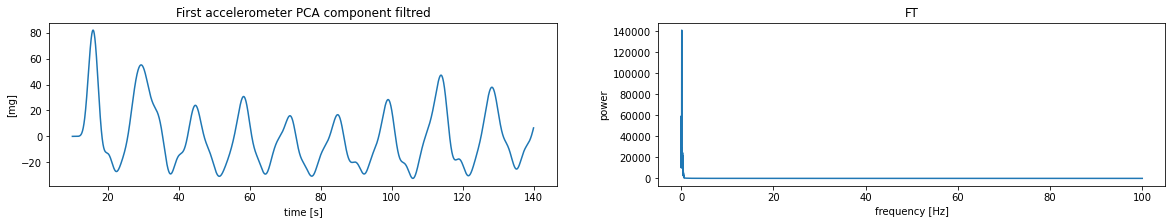

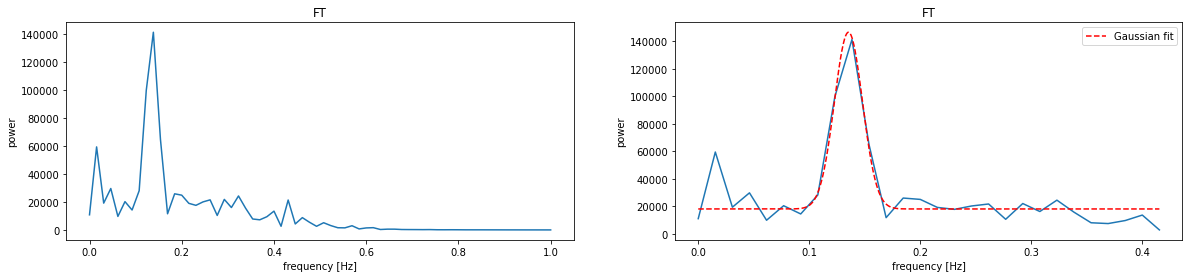

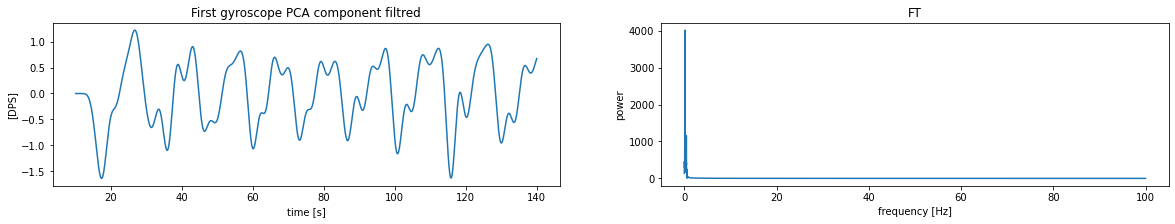

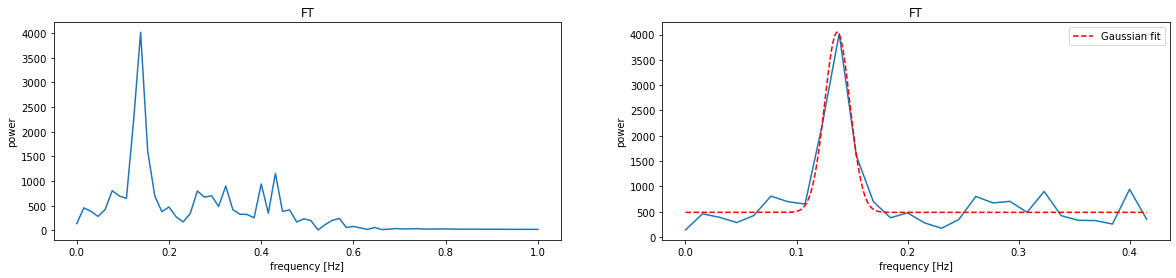

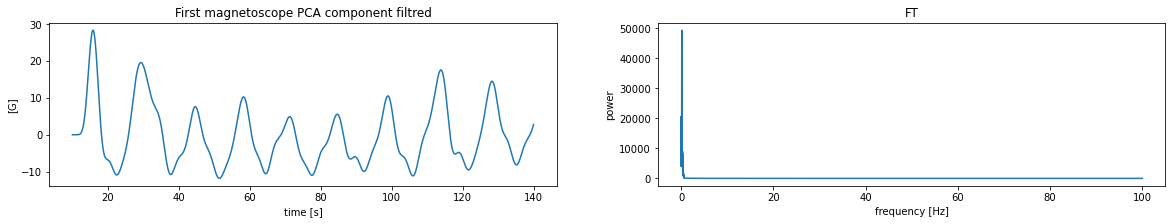

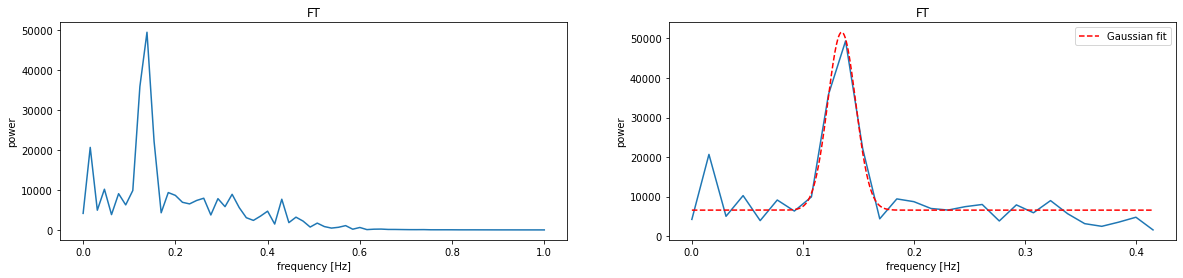

In [37]:
selected_PCA_df2=[accT2[:,0],gyroT2[:,0],magnT2[:,0]]
units=['[mg]','[DPS]','[G]']
component_name=['First accelerometer PCA component filtred', 'First gyroscope PCA component filtred','First magnetoscope PCA component filtred']
RR_butter1=np.zeros(len(selected_PCA_df2))
RR_butter_error1=np.zeros(len(selected_PCA_df2))

for id,(i,j,k) in enumerate(zip(selected_PCA_df2,units,component_name)):   
    RR_butter1[id],RR_butter_error1[id]=butter_filter(df2.index.values,i,0.5,10,sampling_rate,j,k) 
    

In [38]:
# estimating the RR via a weighted average of the peaks
av_butter,av_butter_error=np.average(RR_butter1,weights=1/RR_butter_error1,returned=True)
av_butter_error_perc=abs((av_butter_error*100)/av_butter)

print('RR estimeted via weighted average: {:.3} +/- {:.3} bpm'.format(av_butter,av_butter_error))
print('Percentage of error: {:.3} % \n'.format(av_butter_error_perc))

RR estimeted via weighted average: 8.18 +/- -1.47 bpm
Percentage of error: 18.0 % 



# Bibliography

[1]Torrence, C. and Compo, G. P., “A Practical Guide to Wavelet Analysis.”, <i>Bulletin of the American Meteorological Society</i>, vol. 79, no. 1, pp. 61–78, 1998. doi:10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2.
